# Facial Keypoint Detection

Welcome back for exercise 9! As we told you, the exercises of this lecture can be subdivided into mainly two parts. The first part in which we re-invented the wheel and implemented the most important methods on our own and the second part, where we start using existing libraries (that already have implemented all the methods). It's now time to start playing around with more complex network architectures. 

We've already entered stage two, but with the introduction of Convolutional Neural Networks this week, we are given a very powerful tool that we want to explore in this exercises. Therefore, in this week's exercise your task is to build a Convolutional Neural Network to perform facial keypoint detection. 

Before we start, let's take a look at some example images and corresponding facial keypoints:

<img src='images/key_pts_example.png' width=70% height=70%/>

The facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the images above. These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. and are relevant for a variety of computer vision tasks, such as face filters, emotion recognition, pose recognition, and more. 

## (Optional) Mount folder in Colab

Uncomment thefollowing cell to mount your gdrive if you are using the notebook in google colab:

In [ ]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_09) is given.

"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_09'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)

# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)

# Check manually if all files are present
print(sorted(os.listdir()))
"""


## Set up PyTorch environment in colab
- (OPTIONAL) Enable GPU via Runtime --> Change runtime type --> GPU
- Uncomment the following cell if you are using the notebook in google colab:

In [ ]:
# Optional: install correct libraries in google colab
# !python -m pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchtext==0.12.0+cu113 torchaudio==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !python -m pip install tensorboard==2.8.0 > /dev/null

# 1. Preparation

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from exercise_code.data.facial_keypoints_dataset import FacialKeypointsDataset
from exercise_code.networks.keypoint_nn import (
    DummyKeypointModel,
    KeypointModel
)
from exercise_code.util import (
    show_all_keypoints,
    save_model,
)
from exercise_code.tests import test_keypoint_nn
from time import sleep
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.


<div class="alert alert-warning">
    <h3>Note: Google Colab</h3>
    <p>
In case you don't have a GPU, you can run this notebook on Google Colab where you can access a GPU for free, but you can also run this notebook on your CPU.
         </p>
</div>

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


## Load and Visualize Data
To load the data, we have already prepared a Pytorch Dataset class `FacialKeypointsDataset` for you. You can find it in `exercise_code/data/facial_keypoints_dataset.py`. Run the following cell to download the data and initialize your dataset:

In [3]:
download_url = "https://vision.in.tum.de/webshare/g/i2dl/facial_keypoints.zip"
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, "datasets", "facial_keypoints")
train_dataset = FacialKeypointsDataset(
    train=True,
    transform=transforms.ToTensor(),
    root=data_root,
    download_url=download_url,
)
val_dataset = FacialKeypointsDataset(
    train=False,
    transform=transforms.ToTensor(),
    root=data_root,
)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))


66461696it [00:06, 10530776.65it/s]                                              


Number of training samples: 1546
Number of validation samples: 298


Each sample in our dataset is a dict `{"image": image, "keypoints": keypoints}`, where
 * `image` is a [0-1]-normalized gray-scale image of size 96x96, represented by a torch tensor of shape (CxHxW) with C=1, H=96, W=96
    <img style="float: right;" src='images/key_pts_expl.png' width=50% height=50%/>
 * `keypoints` is the list of K facial keypoints, stored in a torch tensor of shape (Kx2). We have K=15 keypoints that stand for:
   * keypoints[0]: Center of the left eye
   * keypoints[1]: Center of the right eye
   * keypoints[2]: Left eye inner corner
   * keypoints[3]: Left eye outer corner
   * keypoints[4]: Right eye inner corner
   * keypoints[5]: Right eye outer corner
   * keypoints[6]: Left eyebrow inner end
   * keypoints[7]: Left eyebrow outer end
   * keypoints[8]: Right eyebrow inner end
   * keypoints[9]: Right eyebrow outer end
   * keypoints[10]: Nose tip
   * keypoints[11]: Mouth left corner
   * keypoints[12]: Mouth right corner
   * keypoints[13]: Mouth center top lip
   * keypoints[14]: Mouth center bottom lip
   
Each individual facial keypoint is represented by two coordinates (x,y) that specify the horizontal and vertical location of the keypoint respectively. All keypoint values are normalized to be in the range [-1,1], such that:
   * (x=-1,y=-1) corresponds to the top left corner, 
   * (x=-1,y=1) to the bottom left corner,
   * (x=1,y=-1) to the top right corner,
   * (x=1,y=1) to the bottom right corner,
   * and (x=0,y=0) to the center of the image.
   
      
The data downloaded is already preprocessed and hence there is no need to apply transformations in order to prepare the data. Of course, feel free to apply training transformations to improve your performance such as e.g. flipping the training images. </br>

**Note**: The data downloaded is already preprocessed and hence there is **no need** to apply normalization transformations in order to prepare the data. Of course, feel free to apply training transformations to improve your performance such as e.g. flipping the training images. </br>

Also, when applying transformations such as flipping, make sure that the predicted coordinates of your keypoints change accordingly.

Let's have a look at the first training sample to get a better feeling for the dataset:

In [4]:
image, keypoints = train_dataset[0]["image"], train_dataset[0]["keypoints"]
print("Shape of the image:", image.size())
print("Smallest value in the image:", torch.min(image))
print("Largest value in the image:", torch.max(image))
print(image)


Shape of the image: torch.Size([1, 96, 96])
Smallest value in the image: tensor(0.0118)
Largest value in the image: tensor(1.)
tensor([[[0.3804, 0.2039, 0.2275,  ..., 0.9922, 0.9961, 0.9961],
         [0.3333, 0.2157, 0.2588,  ..., 0.9922, 0.9961, 0.9961],
         [0.2941, 0.2588, 0.2902,  ..., 0.9922, 0.9961, 0.9961],
         ...,
         [0.1294, 0.1255, 0.1255,  ..., 0.9255, 1.0000, 1.0000],
         [0.1294, 0.1255, 0.1216,  ..., 0.9490, 0.9843, 0.9804],
         [0.1216, 0.1176, 0.1216,  ..., 0.9255, 1.0000, 0.9922]]])


In [5]:
print(keypoints)


tensor([[ 0.4685, -0.2319],
        [-0.4253, -0.1953],
        [ 0.2908, -0.2214],
        [ 0.5992, -0.2214],
        [-0.2685, -0.2109],
        [-0.5873, -0.1900],
        [ 0.1967, -0.3827],
        [ 0.7656, -0.4295],
        [-0.2035, -0.3758],
        [-0.7389, -0.3573],
        [ 0.0086,  0.2333],
        [ 0.4163,  0.6620],
        [-0.3521,  0.6985],
        [ 0.0138,  0.6045],
        [ 0.0190,  0.9076]])


In `exercise_code/util/vis_utils.py` we also provide you with a function `show_all_keypoints()` that takes in an image and keypoints and displays where the predicted keypoints are in the image. Let's use it to plot the first few images of our training set:

**Note:** if your kernel dies when running the following cell, please uncomment the last line of the imports cell `os.environ['KMP_DUPLICATE_LIB_OK']='True'`and try it again. 

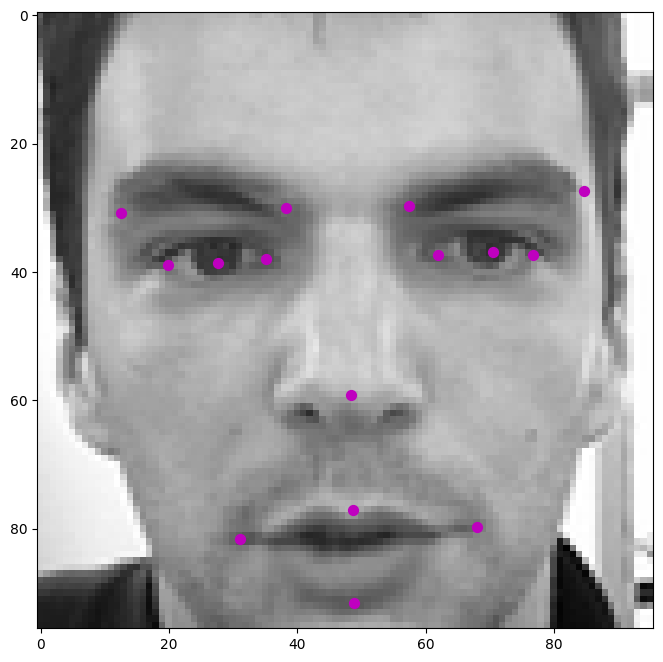

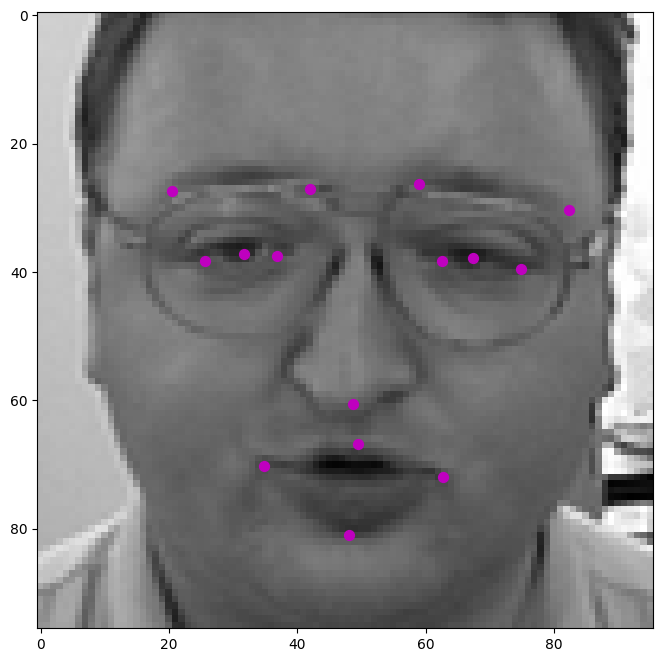

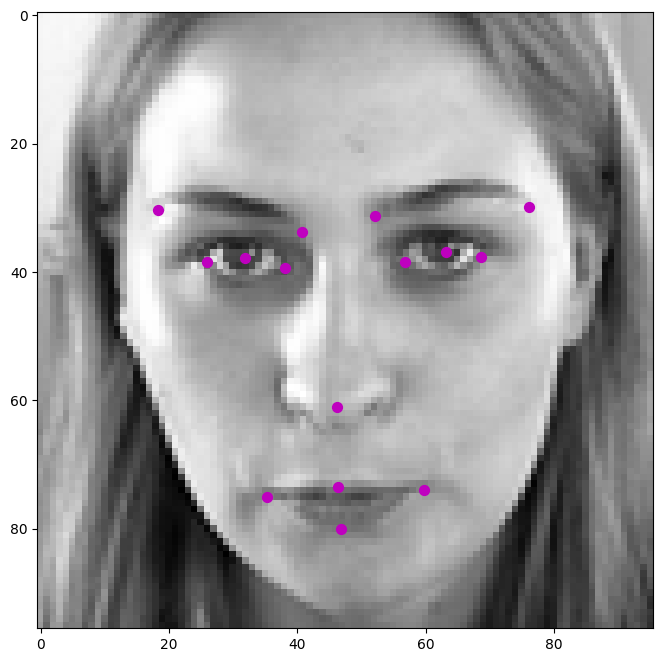

In [6]:
def show_keypoints(dataset, num_samples=3):
    for i in range(num_samples):
        image = dataset[i]["image"]
        key_pts = dataset[i]["keypoints"]
        show_all_keypoints(image, key_pts)


show_keypoints(train_dataset)


# 2. Facial Keypoint Detection
Your task is to define and train a model for facial keypoint detection.

The facial keypoint detection task can be seen as a regression problem, where the goal is to predict 30 different values that correspond to the 15 facial keypoint locations. Thus, we need to build a network that gets a (1x96x96) image as input and predicts 30 continuous outputs between [-1,1].

## Dummy Model

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>In <code>exercise_code/networks/keypoint_nn.py</code> we defined a naive <code>DummyKeypointModel</code>, which always predicts the keypoints of the first training image in the dataset. Let's try it on a few images and visualize our predictions in red:
 </p>
</div>

In [7]:
def show_keypoint_predictions(model, dataset, num_samples=3):
    for i in range(num_samples):
        image = dataset[i]["image"].to(device)
        key_pts = dataset[i]["keypoints"].to(device)
        predicted_keypoints = torch.squeeze(model(image).detach()).view(15, 2)
        show_all_keypoints(image, key_pts, predicted_keypoints)


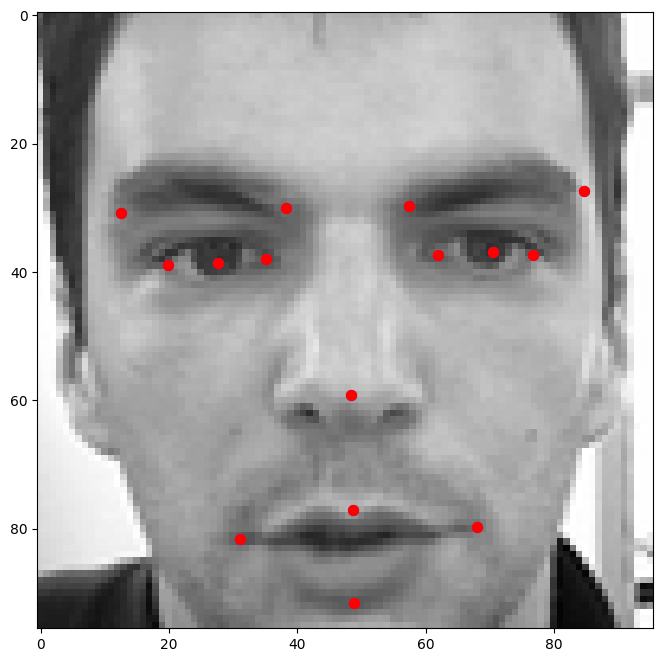

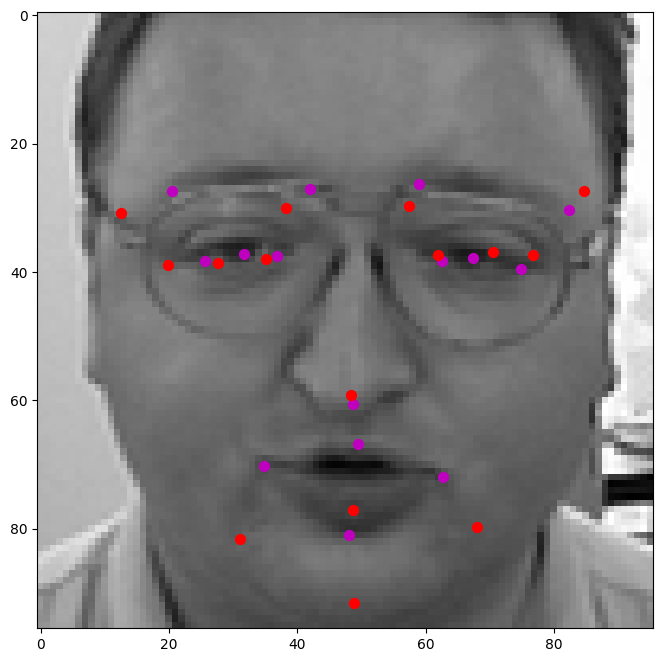

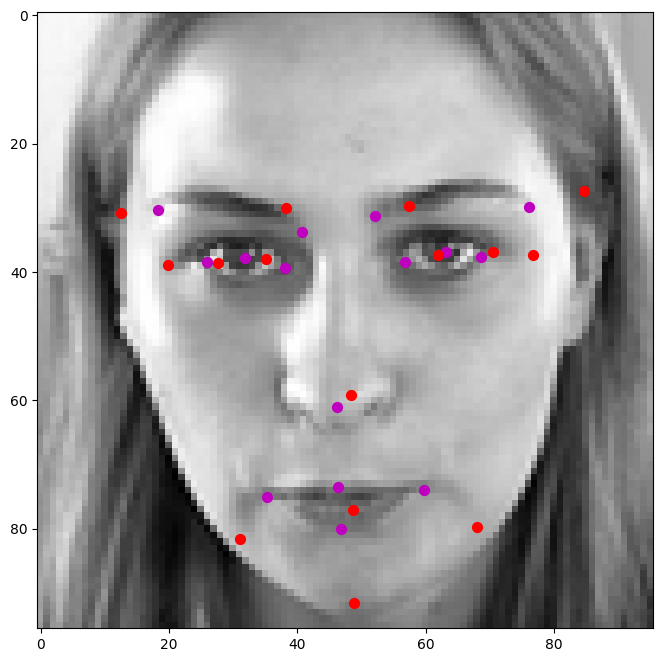

In [8]:
dummy_model = DummyKeypointModel()
show_keypoint_predictions(dummy_model, train_dataset)


As we see, the model predicts the first sample perfectly, but for the remaining samples the predictions are quite off.

## Loss and Metrics

To measure the quality of the model's predictions, we will use the mean squared error (https://en.wikipedia.org/wiki/Mean_squared_error), summed up over all 30 keypoint locations. In PyTorch, the mean squared error is defined in `torch.nn.MSELoss()`, and we can use it like this:

In [9]:
loss_fn = torch.nn.MSELoss()
for i in range(3):
    image = train_dataset[i]["image"]
    keypoints = train_dataset[i]["keypoints"]
    predicted_keypoints = torch.squeeze(dummy_model(image)).view(15, 2)
    loss = loss_fn(keypoints, predicted_keypoints)
    print("Loss on image %d:" % i, loss)


Loss on image 0: tensor(9.3016e-10)
Loss on image 1: tensor(0.0094)
Loss on image 2: tensor(0.0102)


As expected, our dummy model achieves a loss close to 0 on the first sample, but on all other samples the loss is quite high.

To obtain an evaluation score (in the notebook and on the submission server), we will use the following function:

In [10]:
def evaluate_model(model, dataset):
    model.eval()
    model.to(device)
    criterion = torch.nn.MSELoss()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0
    for batch in dataloader:
        image, keypoints = batch["image"].to(device), batch["keypoints"].to(device)
        predicted_keypoints = model(image).view(-1, 15, 2).to(device)
        loss += criterion(
            torch.squeeze(keypoints), torch.squeeze(predicted_keypoints)
        ).item()
    return 1.0 / (2 * (loss / len(dataloader)))


print("Score of the Dummy Model:", evaluate_model(dummy_model, val_dataset))


Score of the Dummy Model: 60.19574441168827


**To pass the assignment, you will need to achieve a score of at least 100**. As you can see, the score is calculated from the average loss, so **your average loss needs to be lower than 0.005**. Our dummy model only gets a score of around 60, so you will have to come up with a better model.

## Step 1: Design your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> Now it is your turn to build your own model. To do so, you need to design a convolution neural network that takes images of size (Nx1x96x96) as input and produces outputs of shape (Nx30) in the range [-1,1]. Therefore, implement the <code>KeypointModel</code> class in <code>exercise_code/networks/keypoint_nn.py</code>.
    </p>
</div>

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Max-pooling layers
* Fully-connected layers

You can design your network however you want, but we strongly suggest to include multiple convolution layers. You are also encouraged to use things like dropout and batch normalization to stabilize and regularize your network. If you want to build a really competitive model, have a look at some literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf).

#### Define your model in the provided file 
`exercise_code/networks/keypoint_nn.py` file

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically).

The only rules your model design has to follow are:
* Perform the forward pass in forward(), predicting keypoints of shape (Nx30) for images of shape (Nx1x96x96)
* Have less than 5 million parameters
* Have a model size of less than 20MB after saving

Furthermore, you need to pass all your hyperparameters to the model in a single dictionary:

In [16]:
hparams = {
    'dropout' : 0.5,
    'batch_size' : 256,
    'num_epochs' : 300
}


To test whether your model follows the basic rules, run the following cell:

In [12]:
model = KeypointModel(hparams)
test_keypoint_nn(model)


KeypointShapeTest passed.
ParamCountTest passed. Your model has 1.888 mio. params.
FileSizeTest passed. Your model is 7.6 MB large
All tests passed for your model. Tests passed: 3/3


## Step 2: Train your model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> In addition to the network itself, you will also need to write the code for the model training.
    </p>
</div>

**Hints:**
* Use `torch.nn.MSELoss()` as loss function.

* You have two options for training code:
    - Use a straightforward training scheme. See 1.pytorch.ipynb from ex07.
    - Don't call your model anything else besides "model", unless you notice that you'll need to modify the model name in the upcoming cells.
    - You could refer to the training scheme from exercise_08 to complete your code. Understanding this pipeline is crucial for future works in deep learning.
    

In [13]:
def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable),total=len(iterable), ncols=150, desc=desc)

In [22]:
########################################################################
# TODO - Train Your Model                                              #
########################################################################

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the classifier.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=False)

model = model.to(device)

# Training loop
for epoch in range(hparams["num_epochs"]):  # replace num_epochs with your actual number of epochs
    model.train()  # set model to training mode
    train_bar = create_tqdm_bar(train_loader, f'Epoch {epoch+1} Training')  # replace with your actual dataloader
    for i, batch in train_bar:
        # Get images and labels from batch
        images = batch["image"].to(device)
        keypoints = batch["keypoints"].to(device)

        # Forward pass
        predicted_keypoints = model(images).view(-1, 15, 2)
        loss = criterion(torch.squeeze(keypoints), torch.squeeze(predicted_keypoints))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        train_bar.set_postfix(loss=loss.item())

    # Validation
    model.eval()  # set model to evaluation mode
    val_bar = create_tqdm_bar(val_loader, f'Epoch {epoch+1} Validation')  # replace with your actual dataloader
    with torch.no_grad():
        total_val_loss = 0
        for i, batch in val_bar:
            # Get images and labels from batch
            images = batch["image"].to(device)
            keypoints = batch["keypoints"].to(device)

            # Forward pass
            predicted_keypoints = model(images).view(-1, 15, 2)
            loss = criterion(torch.squeeze(keypoints), torch.squeeze(predicted_keypoints))
            total_val_loss += loss.item()

            # Update progress bar
            val_bar.set_postfix(val_loss=loss.item())

        # Print average validation loss
        print(f'Epoch {epoch+1}, Validation loss: {total_val_loss/len(val_loader)}')

########################################################################
#                           END OF YOUR CODE                           #
########################################################################


Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s, val_loss=0.0995]


Epoch 1, Validation loss: 0.09913342073559761


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s, val_loss=0.0677]


Epoch 2, Validation loss: 0.06730962544679642


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.98it/s, val_loss=0.0415]


Epoch 3, Validation loss: 0.04126976802945137


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s, val_loss=0.0434]


Epoch 4, Validation loss: 0.043055592104792595


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.93it/s, val_loss=0.0279]


Epoch 5, Validation loss: 0.02767201606184244


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s, val_loss=0.0219]


Epoch 6, Validation loss: 0.021669724956154823


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.0216]


Epoch 7, Validation loss: 0.021377109922468662


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.32it/s, val_loss=0.0218]


Epoch 8, Validation loss: 0.021615690551698208


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s, val_loss=0.0157]


Epoch 9, Validation loss: 0.015458627138286829


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s, val_loss=0.0108]


Epoch 10, Validation loss: 0.0105742821469903


Epoch 11 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s, val_loss=0.0103]


Epoch 11, Validation loss: 0.010128968395292759


Epoch 12 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.13it/s, val_loss=0.0113]


Epoch 12, Validation loss: 0.011193059384822845


Epoch 13 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.09it/s, val_loss=0.0088]


Epoch 13, Validation loss: 0.008637675549834967


Epoch 14 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.08it/s, val_loss=0.0103]


Epoch 14, Validation loss: 0.010144547559320927


Epoch 15 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.55it/s, val_loss=0.0101]


Epoch 15, Validation loss: 0.009891603607684374


Epoch 16 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s, val_loss=0.0089]


Epoch 16, Validation loss: 0.008734127040952444


Epoch 17 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.54it/s, val_loss=0.0102]


Epoch 17, Validation loss: 0.010054257232695818


Epoch 18 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.41it/s, val_loss=0.00868]


Epoch 18, Validation loss: 0.00851163873448968


Epoch 19 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.55it/s, val_loss=0.00721]


Epoch 19, Validation loss: 0.007054892601445317


Epoch 20 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.38it/s, val_loss=0.00922]


Epoch 20, Validation loss: 0.009054397232830524


Epoch 21 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.59it/s, val_loss=0.00951]


Epoch 21, Validation loss: 0.0093410424888134


Epoch 22 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.58it/s, val_loss=0.00749]


Epoch 22, Validation loss: 0.007343259174376726


Epoch 23 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.46it/s, val_loss=0.00771]


Epoch 23, Validation loss: 0.0075717659201473


Epoch 24 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s, val_loss=0.00929]


Epoch 24, Validation loss: 0.00913724722340703


Epoch 25 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.11it/s, val_loss=0.00778]


Epoch 25, Validation loss: 0.007632075576111674


Epoch 26 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s, val_loss=0.00651]


Epoch 26, Validation loss: 0.00635547237470746


Epoch 27 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.58it/s, val_loss=0.0045]


Epoch 27, Validation loss: 0.004379823803901672


Epoch 28 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.06it/s, val_loss=0.00425]


Epoch 28, Validation loss: 0.0041362689808011055


Epoch 29 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s, val_loss=0.00511]


Epoch 29, Validation loss: 0.004983516409993172


Epoch 30 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s, val_loss=0.00659]


Epoch 30, Validation loss: 0.006448881700634956


Epoch 31 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.54it/s, val_loss=0.00639]


Epoch 31, Validation loss: 0.006257650209590793


Epoch 32 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.14it/s, val_loss=0.00484]


Epoch 32, Validation loss: 0.004728387109935284


Epoch 33 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s, val_loss=0.0052]


Epoch 33, Validation loss: 0.005072192521765828


Epoch 34 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s, val_loss=0.0044]


Epoch 34, Validation loss: 0.004286059411242604


Epoch 35 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.11it/s, val_loss=0.00412]


Epoch 35, Validation loss: 0.004025287926197052


Epoch 36 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s, val_loss=0.0051]


Epoch 36, Validation loss: 0.004975351970642805


Epoch 37 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.19it/s, val_loss=0.00403]


Epoch 37, Validation loss: 0.003911150153726339


Epoch 38 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s, val_loss=0.00384]


Epoch 38, Validation loss: 0.00373939611017704


Epoch 39 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s, val_loss=0.00382]


Epoch 39, Validation loss: 0.003733189543709159


Epoch 40 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.45it/s, val_loss=0.00404]


Epoch 40, Validation loss: 0.003923460375517607


Epoch 41 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.55it/s, val_loss=0.00386]


Epoch 41, Validation loss: 0.003750514006242156


Epoch 42 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s, val_loss=0.00366]


Epoch 42, Validation loss: 0.0035721652675420046


Epoch 43 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.53it/s, val_loss=0.00388]


Epoch 43, Validation loss: 0.003780670929700136


Epoch 44 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s, val_loss=0.00368]


Epoch 44, Validation loss: 0.0035743233747780323


Epoch 45 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.30it/s, val_loss=0.00373]


Epoch 45, Validation loss: 0.003640389069914818


Epoch 46 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s, val_loss=0.00371]


Epoch 46, Validation loss: 0.0036221485352143645


Epoch 47 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s, val_loss=0.00359]


Epoch 47, Validation loss: 0.0034995091846212745


Epoch 48 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.27it/s, val_loss=0.00369]


Epoch 48, Validation loss: 0.0035934995394200087


Epoch 49 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.36it/s, val_loss=0.00365]


Epoch 49, Validation loss: 0.00356169231235981


Epoch 50 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.24it/s, val_loss=0.00363]


Epoch 50, Validation loss: 0.003545996150933206


Epoch 51 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.42it/s, val_loss=0.00364]


Epoch 51, Validation loss: 0.0035591510822996497


Epoch 52 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.58it/s, val_loss=0.00355]


Epoch 52, Validation loss: 0.0034688891610130668


Epoch 53 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s, val_loss=0.00357]


Epoch 53, Validation loss: 0.003496734192594886


Epoch 54 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.50it/s, val_loss=0.0036]


Epoch 54, Validation loss: 0.0035318800946697593


Epoch 55 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s, val_loss=0.00361]


Epoch 55, Validation loss: 0.0035443922970443964


Epoch 56 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s, val_loss=0.00378]


Epoch 56, Validation loss: 0.0036992208333685994


Epoch 57 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s, val_loss=0.00365]


Epoch 57, Validation loss: 0.00356261373963207


Epoch 58 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.48it/s, val_loss=0.00367]


Epoch 58, Validation loss: 0.003588181803934276


Epoch 59 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s, val_loss=0.0037]


Epoch 59, Validation loss: 0.003626802354119718


Epoch 60 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s, val_loss=0.00362]


Epoch 60, Validation loss: 0.0035384000511839986


Epoch 61 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.11it/s, val_loss=0.00356]


Epoch 61, Validation loss: 0.0034805440809577703


Epoch 62 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.71it/s, val_loss=0.00352]


Epoch 62, Validation loss: 0.003433311590924859


Epoch 63 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s, val_loss=0.00367]


Epoch 63, Validation loss: 0.003597278264351189


Epoch 64 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.53it/s, val_loss=0.00367]


Epoch 64, Validation loss: 0.0035954437917098403


Epoch 65 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.58it/s, val_loss=0.00359]


Epoch 65, Validation loss: 0.0035107285948470235


Epoch 66 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s, val_loss=0.00356]


Epoch 66, Validation loss: 0.00347500282805413


Epoch 67 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.12it/s, val_loss=0.00369]


Epoch 67, Validation loss: 0.0036260433262214065


Epoch 68 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s, val_loss=0.00355]


Epoch 68, Validation loss: 0.0034785513998940587


Epoch 69 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s, val_loss=0.00358]


Epoch 69, Validation loss: 0.0035012519219890237


Epoch 70 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.10it/s, val_loss=0.00353]


Epoch 70, Validation loss: 0.0034453212283551693


Epoch 71 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s, val_loss=0.00363]


Epoch 71, Validation loss: 0.0035432116128504276


Epoch 72 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.45it/s, val_loss=0.00364]


Epoch 72, Validation loss: 0.003577146213501692


Epoch 73 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s, val_loss=0.0035]


Epoch 73, Validation loss: 0.0034330178750678897


Epoch 74 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s, val_loss=0.00362]


Epoch 74, Validation loss: 0.003542925463989377


Epoch 75 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.53it/s, val_loss=0.00361]


Epoch 75, Validation loss: 0.0035253469832241535


Epoch 76 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s, val_loss=0.00354]


Epoch 76, Validation loss: 0.0034537172177806497


Epoch 77 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s, val_loss=0.00343]


Epoch 77, Validation loss: 0.0033439263934269547


Epoch 78 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.70it/s, val_loss=0.00363]


Epoch 78, Validation loss: 0.0035526128485798836


Epoch 79 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.85it/s, val_loss=0.00356]


Epoch 79, Validation loss: 0.0034860612358897924


Epoch 80 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.54it/s, val_loss=0.00349]


Epoch 80, Validation loss: 0.0034215296618640423


Epoch 81 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s, val_loss=0.00353]


Epoch 81, Validation loss: 0.0034598688362166286


Epoch 82 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.70it/s, val_loss=0.00352]


Epoch 82, Validation loss: 0.0034385421313345432


Epoch 83 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.52it/s, val_loss=0.00347]


Epoch 83, Validation loss: 0.003385053016245365


Epoch 84 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s, val_loss=0.00346]


Epoch 84, Validation loss: 0.0034003163455054164


Epoch 85 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.70it/s, val_loss=0.00355]


Epoch 85, Validation loss: 0.0034853818360716105


Epoch 86 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s, val_loss=0.00342]


Epoch 86, Validation loss: 0.0033388712909072638


Epoch 87 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.16it/s, val_loss=0.0035]


Epoch 87, Validation loss: 0.003430121229030192


Epoch 88 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.71it/s, val_loss=0.00342]


Epoch 88, Validation loss: 0.0033333792816847563


Epoch 89 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s, val_loss=0.00337]


Epoch 89, Validation loss: 0.0032876322511583567


Epoch 90 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s, val_loss=0.00341]


Epoch 90, Validation loss: 0.003326921258121729


Epoch 91 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.26it/s, val_loss=0.00344]


Epoch 91, Validation loss: 0.0033679413609206676


Epoch 92 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s, val_loss=0.00353]


Epoch 92, Validation loss: 0.0034491544356569648


Epoch 93 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.32it/s, val_loss=0.0034]


Epoch 93, Validation loss: 0.0033172088442370296


Epoch 94 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.86it/s, val_loss=0.00339]


Epoch 94, Validation loss: 0.003326230333186686


Epoch 95 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s, val_loss=0.00347]


Epoch 95, Validation loss: 0.003392233280465007


Epoch 96 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.55it/s, val_loss=0.00347]


Epoch 96, Validation loss: 0.003370697842910886


Epoch 97 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.18it/s, val_loss=0.00343]


Epoch 97, Validation loss: 0.003372120321728289


Epoch 98 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s, val_loss=0.00337]


Epoch 98, Validation loss: 0.003302286146208644


Epoch 99 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.71it/s, val_loss=0.00347]


Epoch 99, Validation loss: 0.003370517399162054


Epoch 100 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.50it/s, val_loss=0.00338]


Epoch 100, Validation loss: 0.0032851743744686246


Epoch 101 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.71it/s, val_loss=0.00338]


Epoch 101, Validation loss: 0.003300337237305939


Epoch 102 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.70it/s, val_loss=0.00337]


Epoch 102, Validation loss: 0.00327600899618119


Epoch 103 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.56it/s, val_loss=0.00335]


Epoch 103, Validation loss: 0.003263424849137664


Epoch 104 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s, val_loss=0.00341]


Epoch 104, Validation loss: 0.003327091922983527


Epoch 105 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s, val_loss=0.00348]


Epoch 105, Validation loss: 0.00340455723926425


Epoch 106 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.55it/s, val_loss=0.00348]


Epoch 106, Validation loss: 0.003422080655582249


Epoch 107 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s, val_loss=0.0035]


Epoch 107, Validation loss: 0.003433128702454269


Epoch 108 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.70it/s, val_loss=0.00352]


Epoch 108, Validation loss: 0.0034624473191797733


Epoch 109 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s, val_loss=0.0035]


Epoch 109, Validation loss: 0.003437525243498385


Epoch 110 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.31it/s, val_loss=0.00344]


Epoch 110, Validation loss: 0.003362828283570707


Epoch 111 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s, val_loss=0.00331]


Epoch 111, Validation loss: 0.003230160567909479


Epoch 112 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s, val_loss=0.00342]


Epoch 112, Validation loss: 0.0033593770349398255


Epoch 113 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.94it/s, val_loss=0.00341]


Epoch 113, Validation loss: 0.0033297360641881824


Epoch 114 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s, val_loss=0.00342]


Epoch 114, Validation loss: 0.00332605536095798


Epoch 115 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.30it/s, val_loss=0.00338]


Epoch 115, Validation loss: 0.0032860214123502374


Epoch 116 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.27it/s, val_loss=0.0033]


Epoch 116, Validation loss: 0.0032227375777438283


Epoch 117 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.86it/s, val_loss=0.00333]


Epoch 117, Validation loss: 0.0032450371654704213


Epoch 118 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s, val_loss=0.00352]


Epoch 118, Validation loss: 0.003447940107434988


Epoch 119 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.86it/s, val_loss=0.00349]


Epoch 119, Validation loss: 0.0034364224411547184


Epoch 120 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.85it/s, val_loss=0.00337]


Epoch 120, Validation loss: 0.0032951936591416597


Epoch 121 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.23it/s, val_loss=0.0033]


Epoch 121, Validation loss: 0.0032149271573871374


Epoch 122 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00337]


Epoch 122, Validation loss: 0.003313178545795381


Epoch 123 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.88it/s, val_loss=0.00339]


Epoch 123, Validation loss: 0.003330064471811056


Epoch 124 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s, val_loss=0.00341]


Epoch 124, Validation loss: 0.0033512309892103076


Epoch 125 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.29it/s, val_loss=0.00341]


Epoch 125, Validation loss: 0.0033511610236018896


Epoch 126 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s, val_loss=0.00345]


Epoch 126, Validation loss: 0.0033798147924244404


Epoch 127 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s, val_loss=0.00336]


Epoch 127, Validation loss: 0.0032864902168512344


Epoch 128 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.31it/s, val_loss=0.0034]


Epoch 128, Validation loss: 0.003343277727253735


Epoch 129 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s, val_loss=0.00333]


Epoch 129, Validation loss: 0.0032684924080967903


Epoch 130 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.85it/s, val_loss=0.00351]


Epoch 130, Validation loss: 0.003441150183789432


Epoch 131 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.27it/s, val_loss=0.00341]


Epoch 131, Validation loss: 0.00334113254211843


Epoch 132 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.28it/s, val_loss=0.00341]


Epoch 132, Validation loss: 0.0033539055148139596


Epoch 133 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s, val_loss=0.00339]


Epoch 133, Validation loss: 0.003332564141601324


Epoch 134 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.38it/s, val_loss=0.00337]


Epoch 134, Validation loss: 0.0033024344593286514


Epoch 135 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.69it/s, val_loss=0.00337]


Epoch 135, Validation loss: 0.0033203663770109415


Epoch 136 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.18it/s, val_loss=0.00351]


Epoch 136, Validation loss: 0.003457477199845016


Epoch 137 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.77it/s, val_loss=0.00338]


Epoch 137, Validation loss: 0.0032963943667709827


Epoch 138 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.12it/s, val_loss=0.00341]


Epoch 138, Validation loss: 0.0033199554309248924


Epoch 139 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.69it/s, val_loss=0.00336]


Epoch 139, Validation loss: 0.003288935753516853


Epoch 140 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.32it/s, val_loss=0.00345]


Epoch 140, Validation loss: 0.0033929625060409307


Epoch 141 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.39it/s, val_loss=0.00332]


Epoch 141, Validation loss: 0.003253761096857488


Epoch 142 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.18it/s, val_loss=0.00335]


Epoch 142, Validation loss: 0.003287704079411924


Epoch 143 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s, val_loss=0.00331]


Epoch 143, Validation loss: 0.0032589121256023645


Epoch 144 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s, val_loss=0.00344]


Epoch 144, Validation loss: 0.003380152862519026


Epoch 145 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s, val_loss=0.00343]


Epoch 145, Validation loss: 0.0033696728060021996


Epoch 146 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.92it/s, val_loss=0.00337]


Epoch 146, Validation loss: 0.003317175665870309


Epoch 147 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s, val_loss=0.00327]


Epoch 147, Validation loss: 0.003178584622219205


Epoch 148 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s, val_loss=0.00328]


Epoch 148, Validation loss: 0.0031753575894981623


Epoch 149 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s, val_loss=0.00339]


Epoch 149, Validation loss: 0.003323021112009883


Epoch 150 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s, val_loss=0.00337]


Epoch 150, Validation loss: 0.00330934498924762


Epoch 151 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00337]


Epoch 151, Validation loss: 0.0032926276326179504


Epoch 152 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s, val_loss=0.00336]


Epoch 152, Validation loss: 0.0032855196623131633


Epoch 153 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s, val_loss=0.0033]


Epoch 153, Validation loss: 0.003237838391214609


Epoch 154 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s, val_loss=0.00359]


Epoch 154, Validation loss: 0.0035404006484895945


Epoch 155 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s, val_loss=0.00339]


Epoch 155, Validation loss: 0.0033421132247895002


Epoch 156 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s, val_loss=0.00332]


Epoch 156, Validation loss: 0.003277009120211005


Epoch 157 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s, val_loss=0.00337]


Epoch 157, Validation loss: 0.0033351894235238433


Epoch 158 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s, val_loss=0.00364]


Epoch 158, Validation loss: 0.0035965832648798823


Epoch 159 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00354]


Epoch 159, Validation loss: 0.003489889670163393


Epoch 160 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s, val_loss=0.00362]


Epoch 160, Validation loss: 0.003594790934585035


Epoch 161 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.21it/s, val_loss=0.00344]


Epoch 161, Validation loss: 0.0034022354520857334


Epoch 162 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00332]


Epoch 162, Validation loss: 0.003286792431026697


Epoch 163 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s, val_loss=0.00337]


Epoch 163, Validation loss: 0.0033422905253246427


Epoch 164 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s, val_loss=0.00327]


Epoch 164, Validation loss: 0.003242783830501139


Epoch 165 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s, val_loss=0.00322]


Epoch 165, Validation loss: 0.0031907149823382497


Epoch 166 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s, val_loss=0.00343]


Epoch 166, Validation loss: 0.0034034416312351823


Epoch 167 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.20it/s, val_loss=0.00349]


Epoch 167, Validation loss: 0.0034449518425390124


Epoch 168 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s, val_loss=0.00327]


Epoch 168, Validation loss: 0.0032251888187602162


Epoch 169 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.27it/s, val_loss=0.00337]


Epoch 169, Validation loss: 0.0033234251895919442


Epoch 170 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s, val_loss=0.00331]


Epoch 170, Validation loss: 0.0032486465061083436


Epoch 171 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00325]


Epoch 171, Validation loss: 0.0031768367625772953


Epoch 172 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s, val_loss=0.00342]


Epoch 172, Validation loss: 0.0033863044809550047


Epoch 173 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s, val_loss=0.00336]


Epoch 173, Validation loss: 0.003316699992865324


Epoch 174 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s, val_loss=0.00341]


Epoch 174, Validation loss: 0.003370482474565506


Epoch 175 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s, val_loss=0.0033]


Epoch 175, Validation loss: 0.003249069210141897


Epoch 176 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.27it/s, val_loss=0.00344]


Epoch 176, Validation loss: 0.003404738730750978


Epoch 177 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.29it/s, val_loss=0.00329]


Epoch 177, Validation loss: 0.0032586673041805625


Epoch 178 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00327]


Epoch 178, Validation loss: 0.0032170620979741216


Epoch 179 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s, val_loss=0.00334]


Epoch 179, Validation loss: 0.0032944551203399897


Epoch 180 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.86it/s, val_loss=0.00328]


Epoch 180, Validation loss: 0.003215684089809656


Epoch 181 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s, val_loss=0.00329]


Epoch 181, Validation loss: 0.003214934025891125


Epoch 182 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s, val_loss=0.00325]


Epoch 182, Validation loss: 0.0032161532435566187


Epoch 183 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s, val_loss=0.00355]


Epoch 183, Validation loss: 0.003524362691678107


Epoch 184 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s, val_loss=0.00321]


Epoch 184, Validation loss: 0.0031417011050507426


Epoch 185 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s, val_loss=0.00318]


Epoch 185, Validation loss: 0.0031059988541528583


Epoch 186 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s, val_loss=0.00316]


Epoch 186, Validation loss: 0.0031153849558904767


Epoch 187 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s, val_loss=0.0032]


Epoch 187, Validation loss: 0.0031410707160830498


Epoch 188 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.88it/s, val_loss=0.00321]


Epoch 188, Validation loss: 0.0031596269691362977


Epoch 189 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s, val_loss=0.00331]


Epoch 189, Validation loss: 0.003271391266025603


Epoch 190 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s, val_loss=0.00322]


Epoch 190, Validation loss: 0.0031728203175589442


Epoch 191 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s, val_loss=0.0032]


Epoch 191, Validation loss: 0.0031274487264454365


Epoch 192 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s, val_loss=0.00317]


Epoch 192, Validation loss: 0.0031204934930428863


Epoch 193 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s, val_loss=0.00329]


Epoch 193, Validation loss: 0.0032512550242245197


Epoch 194 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.42it/s, val_loss=0.00319]


Epoch 194, Validation loss: 0.0031272254418581724


Epoch 195 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00309]


Epoch 195, Validation loss: 0.0030506246257573366


Epoch 196 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.20it/s, val_loss=0.00308]


Epoch 196, Validation loss: 0.0030298716155812144


Epoch 197 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s, val_loss=0.00313]


Epoch 197, Validation loss: 0.0030772951431572437


Epoch 198 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.22it/s, val_loss=0.00315]


Epoch 198, Validation loss: 0.003093931241892278


Epoch 199 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s, val_loss=0.00313]


Epoch 199, Validation loss: 0.0030819629319012165


Epoch 200 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s, val_loss=0.00315]


Epoch 200, Validation loss: 0.0030899574048817158


Epoch 201 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s, val_loss=0.00317]


Epoch 201, Validation loss: 0.0030982835451141


Epoch 202 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s, val_loss=0.00317]


Epoch 202, Validation loss: 0.003093105275183916


Epoch 203 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.93it/s, val_loss=0.00326]


Epoch 203, Validation loss: 0.0032271711388602853


Epoch 204 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s, val_loss=0.00319]


Epoch 204, Validation loss: 0.0031526345992460847


Epoch 205 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s, val_loss=0.00322]


Epoch 205, Validation loss: 0.003160931752063334


Epoch 206 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00308]


Epoch 206, Validation loss: 0.003010970540344715


Epoch 207 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s, val_loss=0.00315]


Epoch 207, Validation loss: 0.00311564898584038


Epoch 208 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s, val_loss=0.00325]


Epoch 208, Validation loss: 0.0031919467728585005


Epoch 209 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s, val_loss=0.00354]


Epoch 209, Validation loss: 0.0035047316923737526


Epoch 210 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s, val_loss=0.00325]


Epoch 210, Validation loss: 0.003186327056027949


Epoch 211 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.59it/s, val_loss=0.00317]


Epoch 211, Validation loss: 0.003132771118544042


Epoch 212 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.70it/s, val_loss=0.00304]


Epoch 212, Validation loss: 0.0030366823775693774


Epoch 213 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s, val_loss=0.00316]


Epoch 213, Validation loss: 0.0031523079378530383


Epoch 214 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s, val_loss=0.00332]


Epoch 214, Validation loss: 0.0033009304897859693


Epoch 215 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s, val_loss=0.00319]


Epoch 215, Validation loss: 0.0031902362825348973


Epoch 216 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s, val_loss=0.00319]


Epoch 216, Validation loss: 0.003162773442454636


Epoch 217 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s, val_loss=0.00318]


Epoch 217, Validation loss: 0.003129209973849356


Epoch 218 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.71it/s, val_loss=0.00307]


Epoch 218, Validation loss: 0.003045423189178109


Epoch 219 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s, val_loss=0.00309]


Epoch 219, Validation loss: 0.0030843212734907866


Epoch 220 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s, val_loss=0.00308]


Epoch 220, Validation loss: 0.0030677909962832928


Epoch 221 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.56it/s, val_loss=0.00326]


Epoch 221, Validation loss: 0.003243010491132736


Epoch 222 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s, val_loss=0.00313]


Epoch 222, Validation loss: 0.0030735457548871636


Epoch 223 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s, val_loss=0.00306]


Epoch 223, Validation loss: 0.003032078966498375


Epoch 224 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s, val_loss=0.00296]


Epoch 224, Validation loss: 0.002948404522612691


Epoch 225 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.22it/s, val_loss=0.00304]


Epoch 225, Validation loss: 0.003036902635358274


Epoch 226 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s, val_loss=0.00302]


Epoch 226, Validation loss: 0.002998086391016841


Epoch 227 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.23it/s, val_loss=0.0029]


Epoch 227, Validation loss: 0.0028752597281709313


Epoch 228 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s, val_loss=0.00308]


Epoch 228, Validation loss: 0.003068716963753104


Epoch 229 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s, val_loss=0.00344]


Epoch 229, Validation loss: 0.0034321448765695095


Epoch 230 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s, val_loss=0.00315]


Epoch 230, Validation loss: 0.003128234064206481


Epoch 231 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s, val_loss=0.00333]


Epoch 231, Validation loss: 0.0033397224033251405


Epoch 232 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.19it/s, val_loss=0.00314]


Epoch 232, Validation loss: 0.0031322092982009053


Epoch 233 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.71it/s, val_loss=0.00355]


Epoch 233, Validation loss: 0.003517978824675083


Epoch 234 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.22it/s, val_loss=0.00349]


Epoch 234, Validation loss: 0.0034816787810996175


Epoch 235 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s, val_loss=0.0033]


Epoch 235, Validation loss: 0.0032958261435851455


Epoch 236 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s, val_loss=0.00316]


Epoch 236, Validation loss: 0.0031643155962228775


Epoch 237 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s, val_loss=0.0031]


Epoch 237, Validation loss: 0.00308955495711416


Epoch 238 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.86it/s, val_loss=0.00307]


Epoch 238, Validation loss: 0.0030554941622540355


Epoch 239 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s, val_loss=0.00292]


Epoch 239, Validation loss: 0.002939078724011779


Epoch 240 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s, val_loss=0.00329]


Epoch 240, Validation loss: 0.0032801564084365964


Epoch 241 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s, val_loss=0.00305]


Epoch 241, Validation loss: 0.0030114231631159782


Epoch 242 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s, val_loss=0.00303]


Epoch 242, Validation loss: 0.0029809277039021254


Epoch 243 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s, val_loss=0.00312]


Epoch 243, Validation loss: 0.0030965727055445313


Epoch 244 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s, val_loss=0.00292]


Epoch 244, Validation loss: 0.002883843262679875


Epoch 245 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s, val_loss=0.00304]


Epoch 245, Validation loss: 0.003004632773809135


Epoch 246 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s, val_loss=0.00279]


Epoch 246, Validation loss: 0.0027691239956766367


Epoch 247 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s, val_loss=0.00303]


Epoch 247, Validation loss: 0.003050830215215683


Epoch 248 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s, val_loss=0.00276]


Epoch 248, Validation loss: 0.0027369194431230426


Epoch 249 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.0029]


Epoch 249, Validation loss: 0.0028840091545134783


Epoch 250 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s, val_loss=0.00286]


Epoch 250, Validation loss: 0.0028653485933318734


Epoch 251 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s, val_loss=0.003]


Epoch 251, Validation loss: 0.003005696227774024


Epoch 252 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s, val_loss=0.00315]


Epoch 252, Validation loss: 0.003140540444292128


Epoch 253 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s, val_loss=0.00283]


Epoch 253, Validation loss: 0.0028250820469111204


Epoch 254 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s, val_loss=0.00299]


Epoch 254, Validation loss: 0.002992653753608465


Epoch 255 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.58it/s, val_loss=0.00298]


Epoch 255, Validation loss: 0.002959407400339842


Epoch 256 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s, val_loss=0.00351]


Epoch 256, Validation loss: 0.0035014543682336807


Epoch 257 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00308]


Epoch 257, Validation loss: 0.0030655465088784695


Epoch 258 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s, val_loss=0.00323]


Epoch 258, Validation loss: 0.0032198086846619844


Epoch 259 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00298]


Epoch 259, Validation loss: 0.002968685934320092


Epoch 260 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.19it/s, val_loss=0.00311]


Epoch 260, Validation loss: 0.003129974124021828


Epoch 261 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s, val_loss=0.00322]


Epoch 261, Validation loss: 0.003192704520188272


Epoch 262 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.85it/s, val_loss=0.00336]


Epoch 262, Validation loss: 0.003337641479447484


Epoch 263 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s, val_loss=0.00304]


Epoch 263, Validation loss: 0.0030322433449327946


Epoch 264 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s, val_loss=0.00301]


Epoch 264, Validation loss: 0.002984360442496836


Epoch 265 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.71it/s, val_loss=0.00298]


Epoch 265, Validation loss: 0.0029715481214225292


Epoch 266 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00309]


Epoch 266, Validation loss: 0.003089182311668992


Epoch 267 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00313]


Epoch 267, Validation loss: 0.0031522292410954833


Epoch 268 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s, val_loss=0.00305]


Epoch 268, Validation loss: 0.0030606649816036224


Epoch 269 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s, val_loss=0.00301]


Epoch 269, Validation loss: 0.002987448126077652


Epoch 270 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s, val_loss=0.00291]


Epoch 270, Validation loss: 0.0029027623822912574


Epoch 271 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.17it/s, val_loss=0.00305]


Epoch 271, Validation loss: 0.0030991104431450367


Epoch 272 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00336]


Epoch 272, Validation loss: 0.0034099386539310217


Epoch 273 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s, val_loss=0.00292]


Epoch 273, Validation loss: 0.002897013211622834


Epoch 274 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s, val_loss=0.00301]


Epoch 274, Validation loss: 0.003033471293747425


Epoch 275 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s, val_loss=0.00292]


Epoch 275, Validation loss: 0.0029490384040400386


Epoch 276 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.25it/s, val_loss=0.00288]


Epoch 276, Validation loss: 0.002898300881497562


Epoch 277 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s, val_loss=0.0028]


Epoch 277, Validation loss: 0.0028167873388156295


Epoch 278 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s, val_loss=0.00295]


Epoch 278, Validation loss: 0.002963807201012969


Epoch 279 Validation: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.25it/s, val_loss=0.003]


Epoch 279, Validation loss: 0.002996606519445777


Epoch 280 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s, val_loss=0.00306]


Epoch 280, Validation loss: 0.0030968356877565384


Epoch 281 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.88it/s, val_loss=0.00312]


Epoch 281, Validation loss: 0.00316111883148551


Epoch 282 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s, val_loss=0.00316]


Epoch 282, Validation loss: 0.0032002414809539914


Epoch 283 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.23it/s, val_loss=0.00318]


Epoch 283, Validation loss: 0.003235591226257384


Epoch 284 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s, val_loss=0.00323]


Epoch 284, Validation loss: 0.003268314409069717


Epoch 285 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s, val_loss=0.00314]


Epoch 285, Validation loss: 0.0031641131499782205


Epoch 286 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s, val_loss=0.00349]


Epoch 286, Validation loss: 0.0035155811347067356


Epoch 287 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s, val_loss=0.00336]


Epoch 287, Validation loss: 0.0034106242237612605


Epoch 288 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s, val_loss=0.0032]


Epoch 288, Validation loss: 0.003234465722925961


Epoch 289 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s, val_loss=0.00324]


Epoch 289, Validation loss: 0.003237110795453191


Epoch 290 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s, val_loss=0.00311]


Epoch 290, Validation loss: 0.003112268866971135


Epoch 291 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.32it/s, val_loss=0.00349]


Epoch 291, Validation loss: 0.003528921864926815


Epoch 292 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.29it/s, val_loss=0.00337]


Epoch 292, Validation loss: 0.0033961423905566335


Epoch 293 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.21it/s, val_loss=0.00318]


Epoch 293, Validation loss: 0.0032217962434515357


Epoch 294 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.85it/s, val_loss=0.00373]


Epoch 294, Validation loss: 0.0037679221713915467


Epoch 295 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s, val_loss=0.00334]


Epoch 295, Validation loss: 0.003376606968231499


Epoch 296 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s, val_loss=0.00319]


Epoch 296, Validation loss: 0.0032561698462814093


Epoch 297 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s, val_loss=0.00311]


Epoch 297, Validation loss: 0.0031529234256595373


Epoch 298 Validation: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s, val_loss=0.0034]


Epoch 298, Validation loss: 0.003457144950516522


Epoch 299 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.93it/s, val_loss=0.00313]


Epoch 299, Validation loss: 0.003187465132214129


Epoch 300 Validation: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s, val_loss=0.00331]

Epoch 300, Validation loss: 0.0033469587797299027


When you're done training, run the cells below to visualize some predictions of your model, and to compute a validation score:

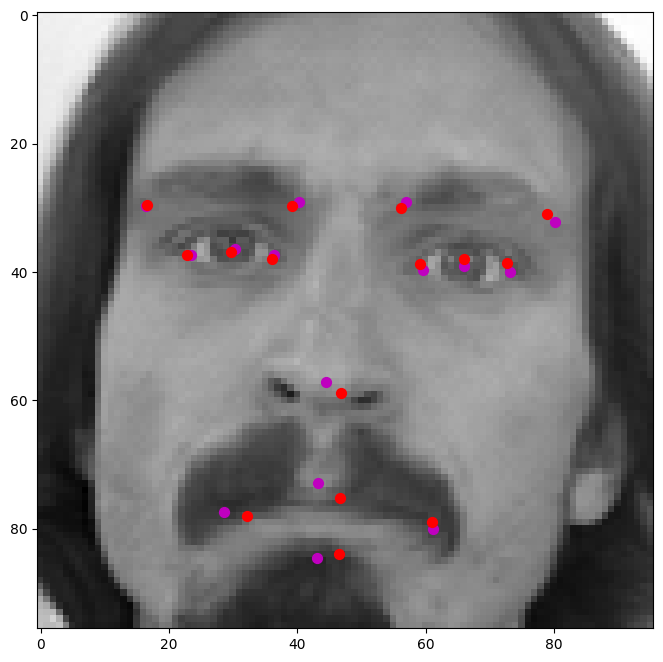

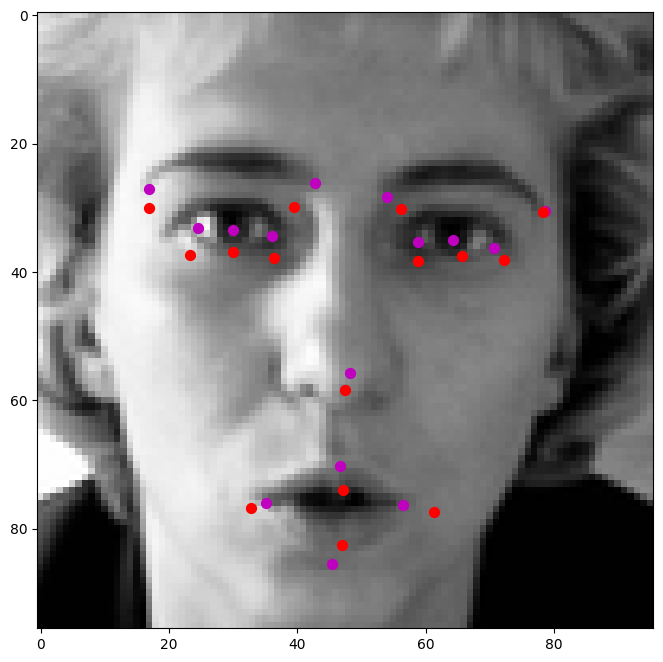

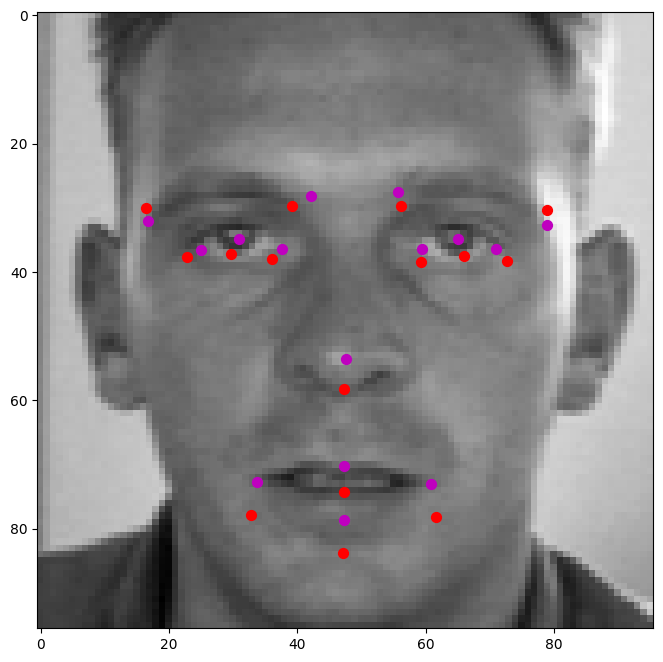

In [23]:
show_keypoint_predictions(model, val_dataset)


In [24]:
print("Score:", evaluate_model(model, val_dataset))


Score: 148.08132819000005


# 3. Save Your Model for Submission

If your model achieved a validation score of 100 or higher, save your model with the cell below and submit it to [the submission server](https://i2dl.vc.in.tum.de/). Your validation set is of course different from the test set on our server, so results may vary. Nevertheless, you will have a reasonable close approximation about your performance.

Before that, we will check again whether the number of parameters is below 5 Mio. and the file size is below 20 MB.

In [25]:
save_model(model, "facial_keypoints.p")


'models/facial_keypoints.p'

Congrats - you've now finished your first Convolution Neural Network! Simply run the following cell to create a zipped file for your implementations.

In [ ]:
# Now zip the folder for upload
from exercise_code.util.submit import submit_exercise

submit_exercise("../output/exercise09")


# Submission Goals

- Goal: Implement and train a convolution neural network for facial keypoint detection.
- Passing Criteria: Reach **Score >= 100** on __our__ test dataset. The submission system will show you your score after you submit.

- Submission start: __June 22, 2023, 10.00__
- Submission deadline: __June 28, 2023 - 15:59__ 
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus

# [Exercise Review](https://docs.google.com/forms/d/e/1FAIpQLSedSHEJ5vN-9FmJN-IGSQ9heDM_8qJQjHL4glgQGlrpQJEYPQ/viewform?usp=pp_url&entry.999074405=Exercise+9:+Facial+Keypoints)
We are always interested in your opinion. Now that you have finished this exercise, we would like you to give us some feedback about the time required to finish the submission and/or work through the notebooks. Please take the short time to fill out our [review form](https://docs.google.com/forms/d/e/1FAIpQLSedSHEJ5vN-9FmJN-IGSQ9heDM_8qJQjHL4glgQGlrpQJEYPQ/viewform?usp=pp_url&entry.999074405=Exercise+9:+Facial+Keypoints) for this exercise so that we can do better next time! :)